***

* [Outline](../0_Introduction/0_introduction.ipynb)
* [Glossary](../0_Introduction/1_glossary.ipynb)
* [6. Deconvolution in Imaging](6_0_introduction.ipynb)  
    * Previous: [6.3 CLEAN Implementations](6_3_clean_flavours.ipynb)  
    * Next: [6.5 Source Finding and Detection](6_5_source_finding.ipynb)

***

Import standard modules:

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML 
HTML('../style/course.css') #apply general CSS

Import section specific modules:

In [7]:
import matplotlib.image as mpimg
from IPython.display import Image
from astropy.io import fits
import aplpy

#Disable astropy/aplpy logging
import logging
logger0 = logging.getLogger('astropy')
logger0.setLevel(logging.CRITICAL)
logger1 = logging.getLogger('aplpy')
logger1.setLevel(logging.CRITICAL)

In [8]:
from IPython.display import HTML
HTML('../style/code_toggle.html')

***

## 6.4 Residuals and Image Quality<a id='deconv:sec:iqa'></a>

Using `CLEAN` or other deconvolution methods produces 'nicer' images than the dirty image (except when deconvolution gets out of control). What it means for an image to be 'nicer' is not a well defined metric, in fact it is almost completely undefined. When we talk of the quality of an image in synthesis imaging we rarely use a quantitative metric, but instead rely on the subjective opinion of the people looking at the image. I know, this is not very scientific. The field of computer vision has been around for decades, this is a field which has developed the objective metrics and techniques for image quality assessment. At some point in the future these methods will need to be incorporated into radio astronomy. This is bound to happen as we have moved to using automated calibration, imaging, and deconvolution pipelines.

We have two some what related questions we need to answer when we are reducing visibilities into a final image:

* When should you halt the deconvolution process?
* What makes a good image?

In [$\S$ 6.2 &#10142;](6_2_clean.ipynb) we covered how we can separate out a sky model from noise using an iterative `CLEAN` deconvolution process. But, we did not discuss at what point we halt the process. There is no well-defined point in which to stop the process. Typically and *ad hoc* decision is made to run deconvolution for a fixed number of iterations or down to a certain flux level. These halting limits are set by adjusting the `CLEAN` parameters until a 'nice' image is produced. Or, if the visibilities have been flux calibrated, which is possible with some arrays, the signal is fixed to some real flux scale. Having knowledge about the array and observation a theoretical noise floor can be computed, then `CLEAN` can be run to a known noise level. One could imagine there is a more automated way to decide when to halt `CLEAN`, perhaps keeping track of the iterations and deciding if there is a convergence?

As a thought experiment we can think about a observation with perfect calibration (we discuss calibration in Chapter 8, but for now it is sufficient to know that the examples we have been using have perfect calibration). When we run `CLEAN` on this observation, each iteration will transfer some flux from the residual image to the sky model (see figure below). If we run this long enough then we will reach the observation noise floor. Then, we will start to deconvolve the noise from the image. And if you run this process for infinite iteration we will eventually have a sky model which contains all the flux, both from the sources and the noise. The residual image in this case will be empty. Now, this extreme case results in our sky model containing noise sources, this is not ideal. But, if we have not deconvoled enough flux then the sky model is incomplete and the residual image will contain PSF structure from the remaining flux. Thus, the challenge is to determine what is enough deconvolution to remove most of the true sky signal but not over-deconvolved such that noise is added to the sky model. As stated earlier, the typical way to do that at the moment is to do multiple deconvolutions, adjusting the parameters until a subjective solution is reached.

We can see an example of over-deconvolution below. Using the same example from the [previous section &#10142;](6_3_clean_flavours.ipynb), if we deconvolve beyond 300 iterations (as we found to result in a well-deconvoled sky model) then noise from the residual image is added to the sky model. This can be seen as the low flux sources around the edge of the image. Over-deconvolution can lead to [<cite data-cite='1998AJ....115.1693C'>clean bias</cite> &#10548;](http://adsabs.harvard.edu/abs/1998AJ....115.1693C) effects.

In [9]:
def generalGauss2d(x0, y0, sigmax, sigmay, amp=1., theta=0.):
    """Return a normalized general 2-D Gaussian function
    x0,y0: centre position
    sigmax, sigmay: standard deviation
    amp: amplitude
    theta: rotation angle (deg)"""
    #norm = amp * (1./(2.*np.pi*(sigmax*sigmay))) #normalization factor
    norm = amp
    rtheta = theta * 180. / np.pi #convert to radians
    
    #general function parameters (https://en.wikipedia.org/wiki/Gaussian_function)
    a = (np.cos(rtheta)**2.)/(2.*(sigmax**2.)) + (np.sin(rtheta)**2.)/(2.*(sigmay**2.))
    b = -1.*(np.sin(2.*rtheta))/(4.*(sigmax**2.)) + (np.sin(2.*rtheta))/(4.*(sigmay**2.))
    c = (np.sin(rtheta)**2.)/(2.*(sigmax**2.)) + (np.cos(rtheta)**2.)/(2.*(sigmay**2.))
    return lambda x,y: norm * np.exp(-1. * (a * ((x - x0)**2.) - 2.*b*(x-x0)*(y-y0) + c * ((y-y0)**2.)))

def genRstoredBeamImg(fitsImg):
    """Generate an image of the restored PSF beam based on the FITS header and image size"""
    fh = fits.open(fitsImg)
    
    #get the restoring beam information from the FITS header
    bmin = fh[0].header['BMIN'] #restored beam minor axis (deg)
    bmaj = fh[0].header['BMAJ'] #restored beam major axis (deg)
    bpa = fh[0].header['BPA'] #restored beam angle (deg)
    dRA = fh[0].header['CDELT1'] #pixel size in RA direction (deg)
    ra0 = fh[0].header['CRPIX1'] #centre RA pixel
    dDec = fh[0].header['CDELT2'] #pixel size in Dec direction (deg)
    dec0 = fh[0].header['CRPIX2'] #centre Dec pixel

    #construct 2-D ellipitcal Gaussian function
    gFunc = generalGauss2d(0., 0., bmin/2., bmaj/2., theta=bpa)

    #produce an restored PSF beam image
    imgSize = 2.*(ra0-1) #assumes a square image
    xpos, ypos = np.mgrid[0:imgSize, 0:imgSize].astype(float) #make a grid of pixel indicies
    xpos -= ra0 #recentre
    ypos -= dec0 #recentre
    xpos *= dRA #convert pixel number to degrees
    ypos *= dDec #convert pixel number to degrees
    return gFunc(xpos, ypos) #restored PSF beam image
    
def convolveBeamSky(beamImg, skyModel):
    """Convolve a beam (PSF or restored) image with a sky model image, images must be the same shape"""
    sampFunc = np.fft.fft2(beamImg) #sampling function
    skyModelVis = np.fft.fft2(skyModel[0,0]) #sky model visibilities
    sampModelVis = sampFunc * skyModelVis #sampled sky model visibilities
    return np.abs(np.fft.fftshift(np.fft.ifft2(sampModelVis))) #sky model convolved with restored beam

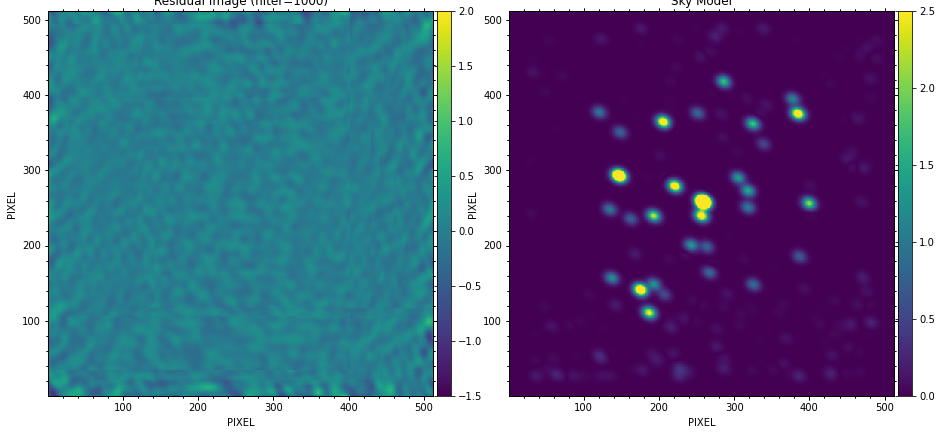

In [10]:
fig = plt.figure(figsize=(16, 7))
    
fh = fits.open('../data/fits/deconv/KAT-7_6h60s_dec-30_10MHz_10chans_uniform_n1000-residual.fits')
residualImg = fh[0].data
fh = fits.open('../data/fits/deconv/KAT-7_6h60s_dec-30_10MHz_10chans_uniform_n1000-model.fits')
skyModel = fh[0].data
    
#generate a retored PSF beam image
restBeam = genRstoredBeamImg(
            '../data/fits/deconv/KAT-7_6h60s_dec-30_10MHz_10chans_uniform_n1000-residual.fits')
    
#convolve restored beam image with skymodel
convImg = convolveBeamSky(restBeam, skyModel)
    
gc1 = aplpy.FITSFigure(residualImg, figure=fig, subplot=[0.1,0.1,0.35,0.8])
gc1.show_colorscale(vmin=-1.5, vmax=2, cmap='viridis')
# gc1.hide_axis_labels()
# gc1.hide_tick_labels()
plt.title('Residual Image (niter=1000)')
gc1.add_colorbar()
    
gc2 = aplpy.FITSFigure(convImg, figure=fig, subplot=[0.5,0.1,0.35,0.8])
gc2.show_colorscale(vmin=0., vmax=2.5, cmap='viridis')
# gc2.hide_axis_labels()
# gc2.hide_tick_labels()
plt.title('Sky Model')
gc2.add_colorbar()
    
fig.canvas.draw()

*Figure: residual image and sky model after 1000 deconvolution iterations. The residual image has been over-deconvolved leading to noise components being added to the sky model.*

The second question of what makes a good image is why we still use subjective opinion. If we consider the realistic case of imaging and deconvolving a real set of visibilities then we have the added problem that there will be always be, at some level, calibration errors. These errors, and cause of these errors, can be identified by a trained eye whether it is poor gain calibration, interference, strong source sidelobes, or any number of other issues. Errors can cause a deconvolution process to diverge resulting in an unrealistic sky model. Humans are very good at looking at images and deciding if they make sense, but we can not easily describe how we do our image processing, thus we find it hard to implement algorithms to do the same. Looking at the dirty image and deconvolved image of the same field below most people would say the deconvoled image is objectively 'better' than the dirty image. Yet we do not know exactly why that is the case.

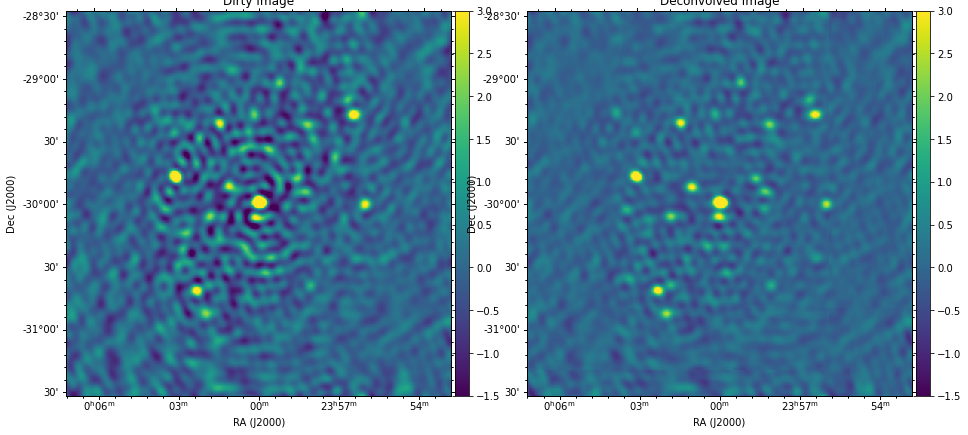

In [11]:
fig = plt.figure(figsize=(16, 7))

gc1 = aplpy.FITSFigure('../data/fits/deconv/KAT-7_6h60s_dec-30_10MHz_10chans_uniform_n100-dirty.fits', \
                       figure=fig, subplot=[0.1,0.1,0.35,0.8])
gc1.show_colorscale(vmin=-1.5, vmax=3., cmap='viridis')
# gc1.hide_axis_labels()
# gc1.hide_tick_labels()
plt.title('Dirty Image')
gc1.add_colorbar()

gc2 = aplpy.FITSFigure('../data/fits/deconv/KAT-7_6h60s_dec-30_10MHz_10chans_uniform_n100-image.fits', \
                       figure=fig, subplot=[0.5,0.1,0.35,0.8])
gc2.show_colorscale(vmin=-1.5, vmax=3., cmap='viridis')
# gc2.hide_axis_labels()
# gc2.hide_tick_labels()
plt.title('Deconvolved Image')
gc2.add_colorbar()

fig.canvas.draw()

*Left: dirty image from a 6 hour KAT-7 observation at a declination of $-30^{\circ}$. Right: deconvolved image.*

The deconvolved image does not have the same noisy PSF structures around the sources that the dirty image does. We could say that these imaging artefacts are localized and related to the PSF response to bright sources. The aim of deconvolution is to remove these PSF like structures and replace them with a simple sky model which is decoupled fro the observing system. Most of difficult work in radio interferometry is the attempt to understand and remove the instrumental effects in order to recover the sky signal. Thus, we have some context for why the deconvolved image is 'better' than the dirty image. The challenge in automatically answering what makes a good image is some how encoding both the context and human intuition. Indeed, a challenge left to the reader.

### 6.4.1 Dynamic Range and Signal-to-Noise Ratio

Dynamic range is the standard metric, which has been used for decades, to describe the quality of an interferometric image. The dynamic range (DR) is defined as the ratio of the peak flux $I_{\textrm{peak}}$ to the standard deviation of the noise in the image $\sigma_I$. The dynamic range can be computed for either a dirty or deconvolved image.

$$\textrm{DR} = \frac{I_{\textrm{peak}}}{\sigma_I}$$

Now this definition of the dynamic range is not well defined. First, how is the peak flux defined? Typically, the peak pixel value anywhere in the image is taken to be the peak flux. But, be careful, changing the resolution of the image will result in different flux values. Decreasing the resolution can result in more flux being included in a single pixel, likewise by increasing the resolution the flux will be spread across more pixels. The second issue is how the noise of the image is computed, possible options are:

1. Use the entire image
2. Use the entire residual image
3. Randomly sample the image
4. Choose a 'relatively' empty region

This is not an exhaustive list of methods, but the typical method is option 4. After deconvolution, the image is loaded into a viewer and the standard deviation of the noise is computed from a region the relatively free of sources. As I write this I am aware of how ridiculous that might sound. Using the same image we can see how the dynamic range varies by using these different methods. The dynamic range for the image deconvolved image above is:

In [13]:
#load deconvolved image
fh = fits.open('../data/fits/deconv/KAT-7_6h60s_dec-30_10MHz_10chans_uniform_n100-image.fits')
deconvImg = fh[0].data
#load residual image
fh = fits.open('../data/fits/deconv/KAT-7_6h60s_dec-30_10MHz_10chans_uniform_n100-residual.fits')
residImg = fh[0].data

peakI = np.max(deconvImg)
print('Peak Flux: %f Jy'%(peakI))

print('Dynamic Range:')
#method 1
noise = np.std(deconvImg)
print('\tMethod 1:', peakI/noise)

#method 2
noise = np.std(residImg)
print('\tMethod 2:', peakI/noise)

#method 3
noise = np.std(np.random.choice(deconvImg.flatten(), int(deconvImg.size*.01))) #randomly sample 1% of pixels
print('\tMethod 3:', peakI/noise)

#method 4, region 1
noise = np.std(deconvImg[0,0,0:128,0:128]) #corner of image
print('\tMethod 4a:', peakI/noise)

#method 4, region 2
noise = np.std(deconvImg[0,0,192:320,192:320]) #centre of image
print('\tMethod 4b:', peakI/noise)

Peak Flux: 9.632476 Jy
Dynamic Range:
	Method 1: 27.607452
	Method 2: 37.685246
	Method 3: 26.35772
	Method 4a: 38.25636
	Method 4b: 11.866578


Method 1 will always result in a lower dynamic range than Method 2 as the deconvoled image includes the sources where method 2 only uses the residuals. Method 3 will result in a dynamic range which varies depending on the number of pixels sampled and which pixels are sampled. One could imagine an unlucky sampling where every pixel chosen is part of a source, resulting in a large standard deviation. Method 4 depends on the region used to compute the noise. In the Method 4a result a corner of the image, where there are essentially no sources, results in a high dynamic range. On the other hand, choosing the centre region to compute the noise standard deviation results in a low dynamic range. This variation between methods can lead to people playing 'the dynamic range game' where someone can pick the result that best fits what they want to say about the image. Be careful, and make sure your dynamic range metric is well defined and unbiased.

There is a qualitative explanation for computing the image noise and the dynamic range by human interaction. Humans are very good at image processing, so we can quickly select regions which are 'noise-like', so it is easier to just look at an image then to try to come up with a complicated algorithm to find these regions. The dynamic range has a number of issues, but it is correlated with image quality. For a fixed visibility set, improving the dynamic range of an image usually results in a improvement in the quality of the image, as determined by a human.

A significant disadvantage to using dynamic range is that it is a global metric which reduced an image down to a single number. It provides no information about local artefacts. This is becoming an important issue in modern synthesis imaging as we push into imaging significant portions of the primary beam and need to account for direction-dependent effects. These topics are discussed in Chapter 7. But, as is noted in [<cite data-cite='taylor1999synthesis'>Synthesis Imaging in Radio Astronomy II (Lecture 13) </cite> &#10548;](http://adsabs.harvard.edu/abs/1999sira.conf.....T) an valid argument can be made for using dynamic range as a proxy (at least a partial one) for image quality. As of this writing dynamic range is the standard method to measure image quality.

### 6.4.2 The Residual Image

We have noted that the results of a deconvolution process is a sky model and a residual image. An example residual image is shown below.

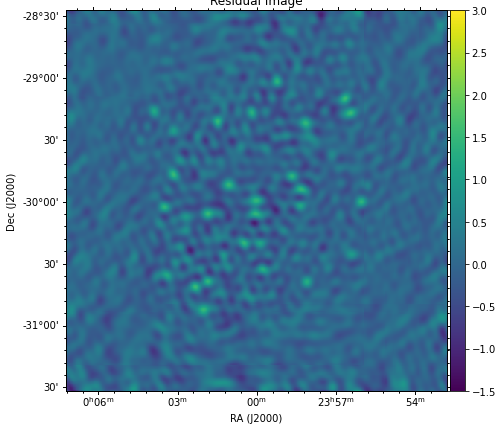

In [14]:
fig = plt.figure(figsize=(8, 7))

gc1 = aplpy.FITSFigure('../data/fits/deconv/KAT-7_6h60s_dec-30_10MHz_10chans_uniform_n100-residual.fits', \
                       figure=fig)
gc1.show_colorscale(vmin=-1.5, vmax=3., cmap='viridis')
# gc1.hide_axis_labels()
# gc1.hide_tick_labels()
plt.title('Residual Image')
gc1.add_colorbar()

fig.canvas.draw()

*Figure: Residual image of a KAT-7 observation resulting from CLEAN deconvolution.*

The image shows that most of the sources bright sources have been deconvolved, but some flux remains. Thus, the centre of the image, where the brightest sources are, is noisier than the edges where the sources are weaker. This is typical as the primary beam is most sensitive at it's centre. This residual image could possibly be further deconvolved but the remaining flux from the sources is close to the image noise and we are in danger of deconvolving into the noise.

The residual image provides the best insight to how well the deconvolution and calibration process was preformed. The ideal residual image is completely noise-like with no apparent structure throughout. This ideal is rarely reached as there is often deconvolution or calibration artefacts present. Looking at the residual image you can determine if there are poorly calibrated baselines, RFI present, not enough devolution, the wrong deconvolution parameters, the w-term correction has not been applied, there are direction-dependent effects unaccounted for, remaining extended structure, or any number of other effects. Inspection of the residual image for these different effects requires intuition which will develop with time.

### 6.4.3 Image Quality Assessment

Assessing the quality of a sythnesized image is an open problem in interferometry. By default we use subjective human assessment. But this approach is not very scientific and can result in different measures of quality for the same image. With any hope this section will soon be expanded with better solutions to the image quality assessment problem.

The process of deconvolution produces a sky model, but that model may not be realistic in `CLEAN` where the sky model is a set of $\delta$-functions even if a source is extended. We can take sky modelling one step further by using source finding techniques to determine what in the sky model is an isolated source, what is a collection of nearby components which make up an extended source, or what is noise which resulted from an imperfect deconvolution. This will be discussed in the next section.

***

Next: [6.5 Source Finding and Detection](6_5_source_finding.ipynb)

<div class=warn><b>Future Additions:</b></div>

* examples of under and over deconvolution
* examples of poor deconvolution of extended sources with CLEAN
* example: deconvolve the same field (cygnus a?) with different methods and show results
* examples: sources of imaging artefacts, need real data examples